In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import pickle

from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional

2022-12-13 10:08:23.389385: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
metadata = pd.read_csv("/datasets/nicolas_facchinetti/processed_data/emodb/metadata_final.csv")
# metadata = pd.read_csv("D:\\Scuola\\TesiMag\\thesis_adversarial_ml_audio\\processed_data//emodb/metadata_final.csv")
metadata

,path,filename,chunk,label,actor,gender,mod
0,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,0
1,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,1,sad,13,f,0
2,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,1
3,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,1,sad,13,f,1
4,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,1
...,...,...,...,...,...,...,...
4144,/datasets/nicolas_facchinetti/emodb/data/08b01...,08b01Fe.wav,0,happy,8,f,2
4145,/datasets/nicolas_facchinetti/emodb/data/08b01...,08b01Fe.wav,1,happy,8,f,2
4146,/datasets/nicolas_facchinetti/emodb/data/08b01...,08b01Fe.wav,0,happy,8,f,2
4147,/datasets/nicolas_facchinetti/emodb/data/08b01...,08b01Fe.wav,0,happy,8,f,2


In [3]:
# data = pickle.load(open("D:\\Scuola\\TesiMag\\thesis_adversarial_ml_audio\\processed_data/emodb/processed_data.p", "rb" ))
data = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emodb/processed_data.p", "rb" ))
data['x'].shape, data['y'].shape

((4149, 261, 128, 1), (4149, 5))

In [4]:
def leave_one_speaker_out(data, n=5):
    speakers = data.actor.unique()
    # random select n actors as test
    np.random.seed(1997)
    selected = np.random.choice(speakers, size=n, replace=False)
    
    myCViterator = []
    for i in selected:
        # take all but not actor i data
        trainIndices = data[~(data['actor']==i)].index.values.astype(int)
        # take only original samples
        testIndices =  data[(data['actor']==i)].index.values.astype(int)
        
        np.random.shuffle(trainIndices)
        np.random.shuffle(testIndices)
        myCViterator.append((trainIndices, testIndices))
    return myCViterator

In [5]:
kf = leave_one_speaker_out(metadata, n=3)         

In [6]:
kf

[(array([  91, 1603,  439, ..., 1772, 3296, 3291]),
  array([3971, 1206, 3810, 1215, 2748,  838, 3973, 3013,  811, 2269,  758,
          753, 3014, 1807, 1018,  623, 1940,  244, 1019,  120, 3122, 1022,
          754, 1647, 2747, 1208, 1299,   80, 4062,  843,  629, 1939,   76,
          688, 1800,  814, 1982, 2237, 2602,   82,  121, 1977, 2060, 3919,
         1562, 2240,  815, 2061, 3924,  761, 1551, 1804, 2606, 1298, 2234,
         2056, 2751, 2542, 1556, 1976, 1544, 1516, 1987, 4053,   85, 1803,
          840, 3134, 1988, 2603,  751, 2539, 2950, 3922, 1310, 3916,  119,
         2945, 1548, 1801,  112, 2924, 1549, 2059, 4052, 1985,   84,  687,
          836,  839, 1972,  748, 2608, 1303, 1547, 1558,   89, 1984, 2268,
         1557, 2927, 2947, 1644, 1555, 1514, 1989, 2543, 4022,  750, 3132,
         1541, 3015, 4061, 1808, 1805, 3121, 1546, 3974,   77,   83, 1213,
         3173, 1560, 2943, 2951, 3010, 3009, 4016, 2267, 2610,  624, 3808,
         1539,  690,  812, 3174, 1935, 4017,  39

In [7]:
kf[0][0]

array([  91, 1603,  439, ..., 1772, 3296, 3291])

In [8]:
metadata.iloc[kf[0][0]]

,path,filename,chunk,label,actor,gender,mod
91,/datasets/nicolas_facchinetti/emodb/data/14a05...,14a05Wa.wav,0,angry,14,f,0
1603,/datasets/nicolas_facchinetti/emodb/data/11b10...,11b10Td.wav,1,sad,11,m,2
439,/datasets/nicolas_facchinetti/emodb/data/15a04...,15a04Fd.wav,0,happy,15,m,1
1506,/datasets/nicolas_facchinetti/emodb/data/16a01...,16a01Fc.wav,0,happy,16,f,1
2704,/datasets/nicolas_facchinetti/emodb/data/08b10...,08b10Tc.wav,0,sad,8,f,1
...,...,...,...,...,...,...,...
3191,/datasets/nicolas_facchinetti/emodb/data/09a05...,09a05Tb.wav,0,sad,9,f,2
2584,/datasets/nicolas_facchinetti/emodb/data/14b02...,14b02Aa.wav,0,fear,14,f,1
1772,/datasets/nicolas_facchinetti/emodb/data/16b10...,16b10Wb.wav,0,angry,16,f,1
3296,/datasets/nicolas_facchinetti/emodb/data/08a07...,08a07Ta.wav,0,sad,8,f,1


<AxesSubplot:>

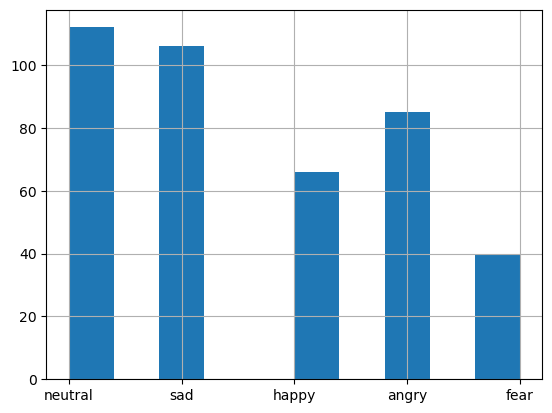

In [26]:
metadata.iloc[kf[0][1]].label.hist()

<AxesSubplot:>

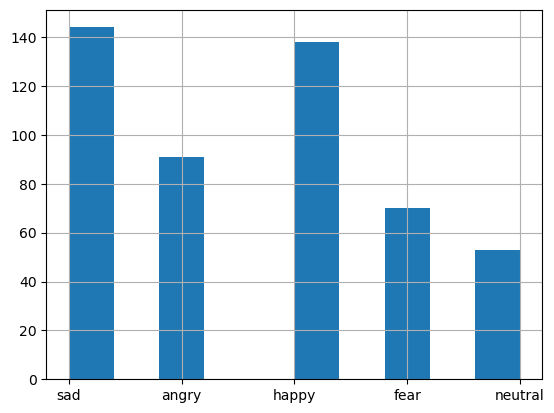

In [27]:
metadata.iloc[kf[1][1]].label.hist()

<AxesSubplot:>

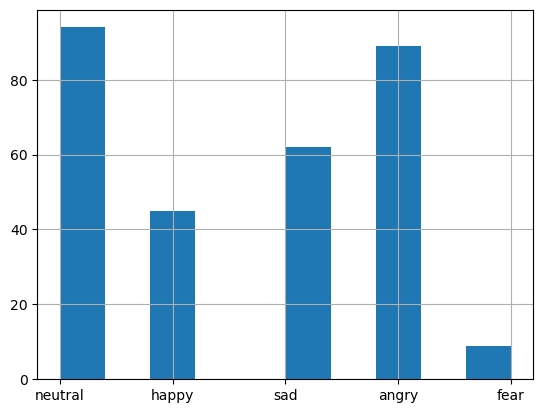

In [25]:
metadata.iloc[kf[2][1]].label.hist()

In [10]:
import matplotlib.pyplot as plt

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()

In [11]:
def train_evaluate(model_fn, train, val, opt='adam'):
    m = model_fn()
    m.compile(loss='categorical_crossentropy', optimizer=opt, metrics='accuracy')
    # fit & predict
    history = m.fit(train[0], train[1],
                    epochs=30,
                    validation_data=(val[0], val[1]),
                    verbose=1)
    print("Done")
    return history

In [12]:
cat = metadata["label"].unique()
cat

array(['sad', 'fear', 'neutral', 'happy', 'angry'], dtype=object)

In [13]:
def train_kfold(kf, metadata, model_fn, x, y):
    results = []
    for train_index, val_index in kf:
        x_train = x[train_index]
        y_train = y[train_index]
        x_test = x[val_index]
        y_test = y[val_index]
        
        results.append(train_evaluate(model_fn, (x_train, y_train), (x_test, y_test)))
    return results

# Models

In [14]:
def get_m12():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(8, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(1, return_sequences=False, dropout=0.2),
            
            Dense(5, activation='softmax')
    ])
    return m

get_m12().summary()

2022-12-13 10:08:31.318103: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-13 10:08:31.319266: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-13 10:08:31.408500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2022-12-13 10:08:31.408534: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-13 10:08:31.410292: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-13 10:08:31.410381: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 9, 25, 124, 8)     208       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 25, 124, 8)     32        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 12, 62, 8)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 10, 60, 16)     1168      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 9, 9, 59, 16)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 9, 8496)           0

In [15]:
t1 = train_kfold(kf, metadata, get_m12, data['x'], data['y'])

2022-12-13 10:08:32.949210: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-13 10:08:32.964099: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3301490000 Hz


Epoch 1/30


2022-12-13 10:08:33.900319: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-13 10:08:34.089999: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


117/117 [==============================] - 4s 16ms/step - loss: 1.6054 - accuracy: 0.2538 - val_loss: 1.6032 - val_accuracy: 0.2592
Epoch 2/30
117/117 [==============================] - 1s 11ms/step - loss: 1.6031 - accuracy: 0.2411 - val_loss: 1.5993 - val_accuracy: 0.2592
Epoch 3/30
117/117 [==============================] - 1s 11ms/step - loss: 1.6006 - accuracy: 0.2490 - val_loss: 1.5964 - val_accuracy: 0.2592
Epoch 4/30
117/117 [==============================] - 1s 12ms/step - loss: 1.6010 - accuracy: 0.2433 - val_loss: 1.5942 - val_accuracy: 0.2592
Epoch 5/30
117/117 [==============================] - 1s 12ms/step - loss: 1.5980 - accuracy: 0.2575 - val_loss: 1.5931 - val_accuracy: 0.2592
Epoch 6/30
117/117 [==============================] - 1s 12ms/step - loss: 1.5963 - accuracy: 0.2466 - val_loss: 1.5832 - val_accuracy: 0.3447
Epoch 7/30
117/117 [==============================] - 1s 12ms/step - loss: 1.4938 - accuracy: 0.3488 - val_loss: 1.6161 - val_accuracy: 0.1785
Epoch 8/30

115/115 [==============================] - 1s 12ms/step - loss: 1.1560 - accuracy: 0.4497 - val_loss: 2.0551 - val_accuracy: 0.1835
Epoch 29/30
115/115 [==============================] - 1s 12ms/step - loss: 1.1411 - accuracy: 0.4607 - val_loss: 2.0954 - val_accuracy: 0.1835
Epoch 30/30
115/115 [==============================] - 1s 12ms/step - loss: 1.1308 - accuracy: 0.4572 - val_loss: 2.1375 - val_accuracy: 0.1835
Done
Epoch 1/30
121/121 [==============================] - 3s 14ms/step - loss: 1.6074 - accuracy: 0.2439 - val_loss: 1.6035 - val_accuracy: 0.2074
Epoch 2/30
121/121 [==============================] - 1s 11ms/step - loss: 1.5912 - accuracy: 0.2834 - val_loss: 1.6005 - val_accuracy: 0.2074
Epoch 3/30
121/121 [==============================] - 1s 11ms/step - loss: 1.6044 - accuracy: 0.2424 - val_loss: 1.5984 - val_accuracy: 0.2074
Epoch 4/30
121/121 [==============================] - 1s 11ms/step - loss: 1.6005 - accuracy: 0.2566 - val_loss: 1.5971 - val_accuracy: 0.2074
Epo

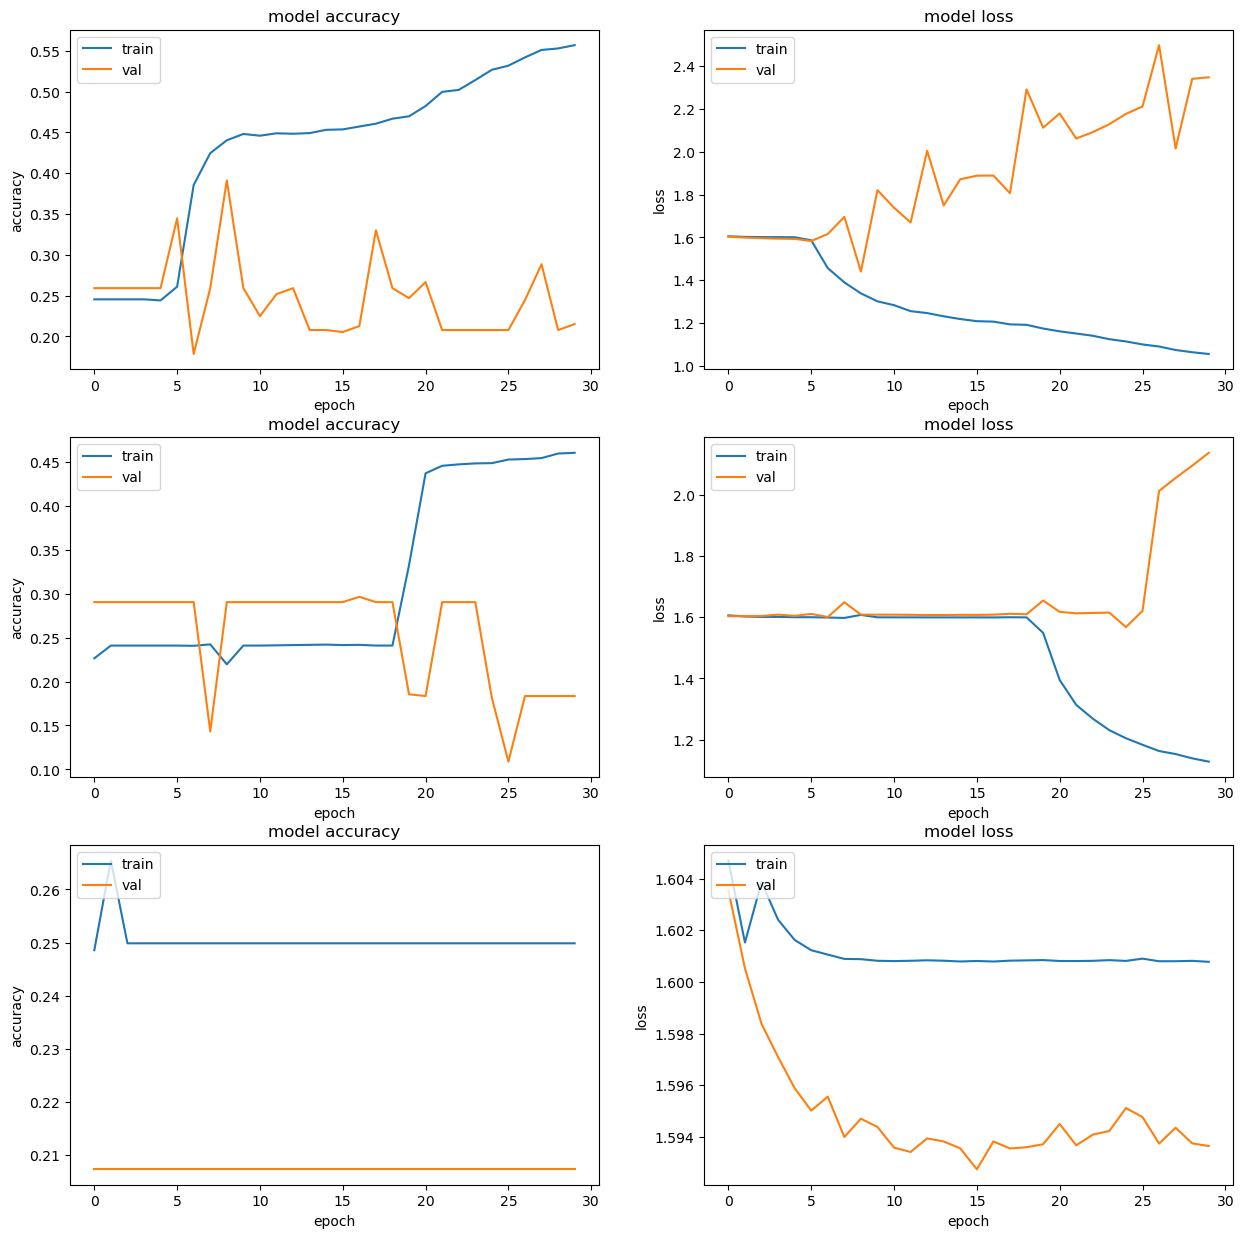

In [16]:
plot_stats(t1)

In [19]:
def get_m2():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(8, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(1, return_sequences=False, dropout=0.2),
            
            Dense(5, activation='softmax')
    ])
    return m

get_m2().summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 9, 25, 124, 8)     208       
_________________________________________________________________
time_distributed_31 (TimeDis (None, 9, 25, 124, 8)     32        
_________________________________________________________________
time_distributed_32 (TimeDis (None, 9, 12, 62, 8)      0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 9, 10, 60, 16)     1168      
_________________________________________________________________
time_distributed_34 (TimeDis (None, 9, 9, 59, 16)      0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 9, 7, 57, 32)     

In [20]:
t2 = train_kfold(kf, metadata, get_m2, data['x'], data['y'])

Epoch 1/30
117/117 [==============================] - 3s 16ms/step - loss: 1.6074 - accuracy: 0.2035 - val_loss: 1.5995 - val_accuracy: 0.2592
Epoch 2/30
117/117 [==============================] - 1s 13ms/step - loss: 1.6055 - accuracy: 0.2415 - val_loss: 1.5927 - val_accuracy: 0.2592
Epoch 3/30
117/117 [==============================] - 1s 13ms/step - loss: 1.6037 - accuracy: 0.2415 - val_loss: 1.5931 - val_accuracy: 0.2592
Epoch 4/30
117/117 [==============================] - 1s 13ms/step - loss: 1.6026 - accuracy: 0.2406 - val_loss: 1.5914 - val_accuracy: 0.2592
Epoch 5/30
117/117 [==============================] - 1s 13ms/step - loss: 1.6025 - accuracy: 0.2361 - val_loss: 1.5882 - val_accuracy: 0.2592
Epoch 6/30
117/117 [==============================] - 1s 13ms/step - loss: 1.6027 - accuracy: 0.2429 - val_loss: 1.5887 - val_accuracy: 0.2592
Epoch 7/30
117/117 [==============================] - 1s 13ms/step - loss: 1.5332 - accuracy: 0.3375 - val_loss: 1.7085 - val_accuracy: 0.2225

Epoch 28/30
115/115 [==============================] - 1s 13ms/step - loss: 1.5996 - accuracy: 0.2394 - val_loss: 1.6088 - val_accuracy: 0.2903
Epoch 29/30
115/115 [==============================] - 1s 13ms/step - loss: 1.6003 - accuracy: 0.2363 - val_loss: 1.6088 - val_accuracy: 0.2903
Epoch 30/30
115/115 [==============================] - 1s 13ms/step - loss: 1.5962 - accuracy: 0.2487 - val_loss: 1.6086 - val_accuracy: 0.2903
Done
Epoch 1/30
121/121 [==============================] - 3s 15ms/step - loss: 1.6056 - accuracy: 0.2483 - val_loss: 1.6047 - val_accuracy: 0.2074
Epoch 2/30
121/121 [==============================] - 2s 13ms/step - loss: 1.6034 - accuracy: 0.2465 - val_loss: 1.6010 - val_accuracy: 0.2074
Epoch 3/30
121/121 [==============================] - 2s 13ms/step - loss: 1.6003 - accuracy: 0.2539 - val_loss: 1.5978 - val_accuracy: 0.2074
Epoch 4/30
121/121 [==============================] - 2s 13ms/step - loss: 1.5994 - accuracy: 0.2565 - val_loss: 1.5961 - val_accuracy

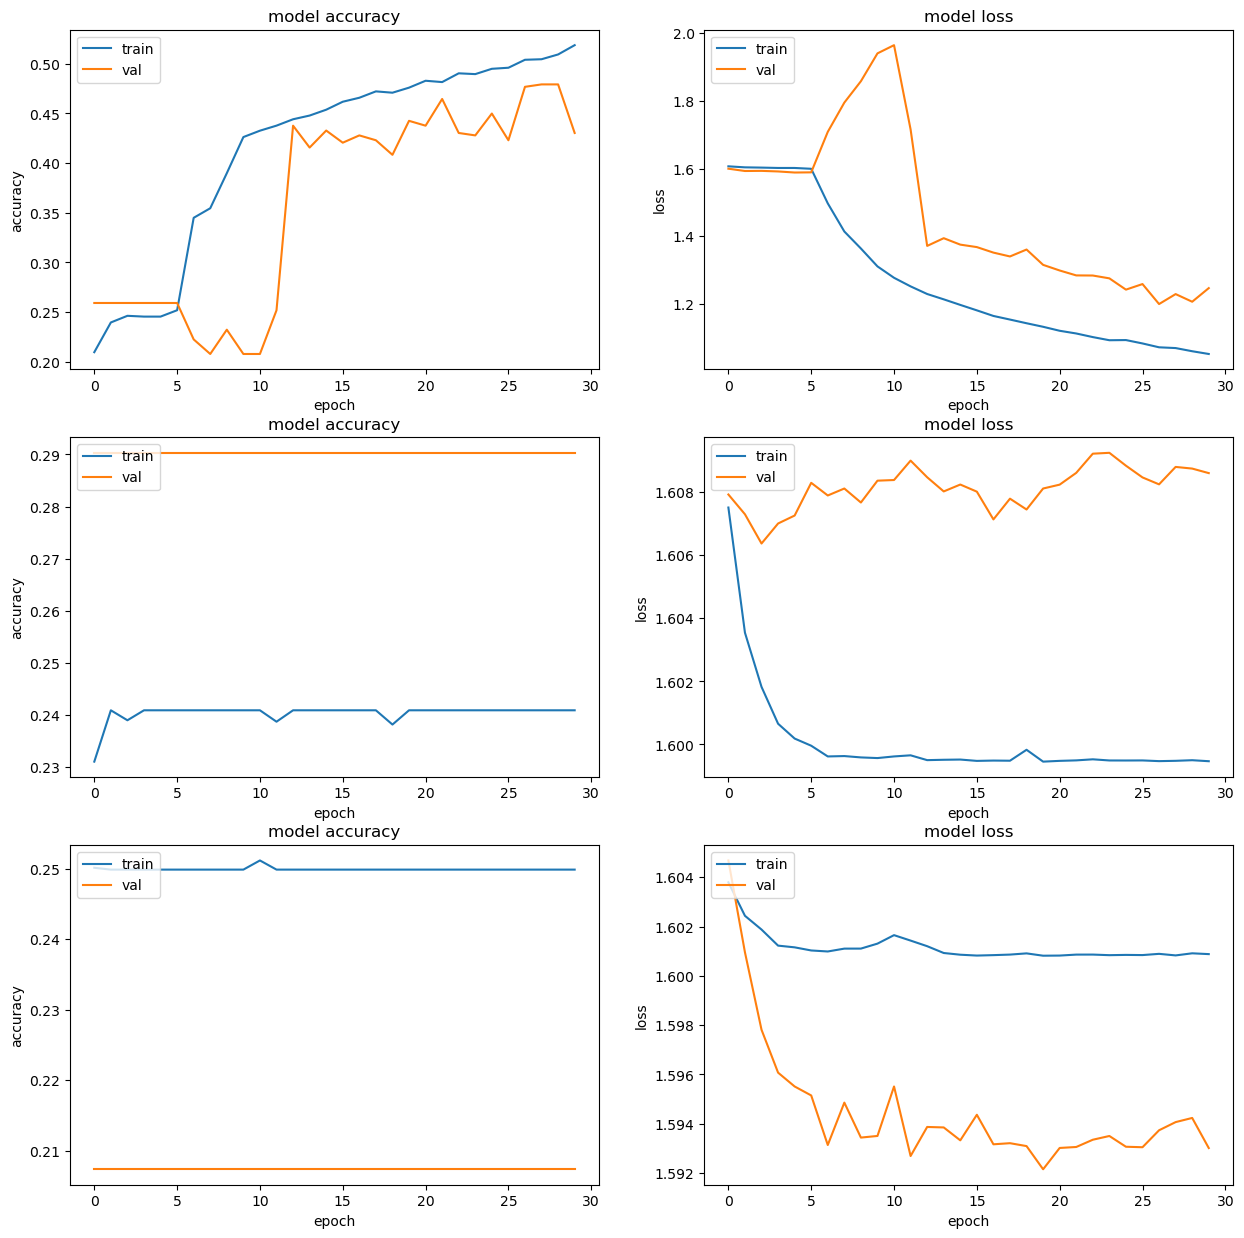

In [21]:
plot_stats(t2)

In [30]:
def get_m3():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Conv2D(8, kernel_size=(5,5), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2,2), strides=2),

            Conv2D(16, kernel_size=(3,3), activation='relu'),
            MaxPooling2D(pool_size=(2,2), strides=1),
            Conv2D(32, kernel_size=(3,3), activation='relu'),
            MaxPooling2D(pool_size=(2,2), strides=1),
            Flatten(),
            Dense(16, activation='relu'),
            Dense(5, activation='softmax')
    ])
    return m

get_m3().summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 257, 124, 8)       208       
_________________________________________________________________
batch_normalization_11 (Batc (None, 257, 124, 8)       32        
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 128, 62, 8)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 126, 60, 16)       1168      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 125, 59, 16)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 123, 57, 32)       4640      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 122, 56, 32)     

In [31]:
t3 = train_kfold(kf, metadata, get_m3, data['x'], data['y'])

Epoch 1/30
117/117 [==============================] - 2s 14ms/step - loss: 1.6088 - accuracy: 0.2525 - val_loss: 1.6036 - val_accuracy: 0.2592
Epoch 2/30
117/117 [==============================] - 1s 12ms/step - loss: 1.6045 - accuracy: 0.2433 - val_loss: 1.5961 - val_accuracy: 0.2592
Epoch 3/30
117/117 [==============================] - 1s 12ms/step - loss: 1.6007 - accuracy: 0.2554 - val_loss: 1.5932 - val_accuracy: 0.2592
Epoch 4/30
117/117 [==============================] - 1s 12ms/step - loss: 1.6026 - accuracy: 0.2451 - val_loss: 1.5916 - val_accuracy: 0.2592
Epoch 5/30
117/117 [==============================] - 1s 12ms/step - loss: 1.6053 - accuracy: 0.2376 - val_loss: 1.5910 - val_accuracy: 0.2592
Epoch 6/30
117/117 [==============================] - 1s 12ms/step - loss: 1.6023 - accuracy: 0.2413 - val_loss: 1.5902 - val_accuracy: 0.2592
Epoch 7/30
117/117 [==============================] - 1s 12ms/step - loss: 1.6032 - accuracy: 0.2408 - val_loss: 1.5906 - val_accuracy: 0.2592

Epoch 28/30
115/115 [==============================] - 1s 13ms/step - loss: 1.6005 - accuracy: 0.2449 - val_loss: 1.6095 - val_accuracy: 0.2903
Epoch 29/30
115/115 [==============================] - 1s 12ms/step - loss: 1.5974 - accuracy: 0.2434 - val_loss: 1.6088 - val_accuracy: 0.2903
Epoch 30/30
115/115 [==============================] - 1s 12ms/step - loss: 1.5977 - accuracy: 0.2459 - val_loss: 1.6088 - val_accuracy: 0.2903
Done
Epoch 1/30
121/121 [==============================] - 2s 14ms/step - loss: 1.6045 - accuracy: 0.2467 - val_loss: 1.5679 - val_accuracy: 0.2074
Epoch 2/30
121/121 [==============================] - 1s 12ms/step - loss: 1.6028 - accuracy: 0.2464 - val_loss: 1.6090 - val_accuracy: 0.2074
Epoch 3/30
121/121 [==============================] - 1s 12ms/step - loss: 1.6041 - accuracy: 0.2483 - val_loss: 1.6009 - val_accuracy: 0.2074
Epoch 4/30
121/121 [==============================] - 1s 12ms/step - loss: 1.5985 - accuracy: 0.2593 - val_loss: 1.5975 - val_accuracy

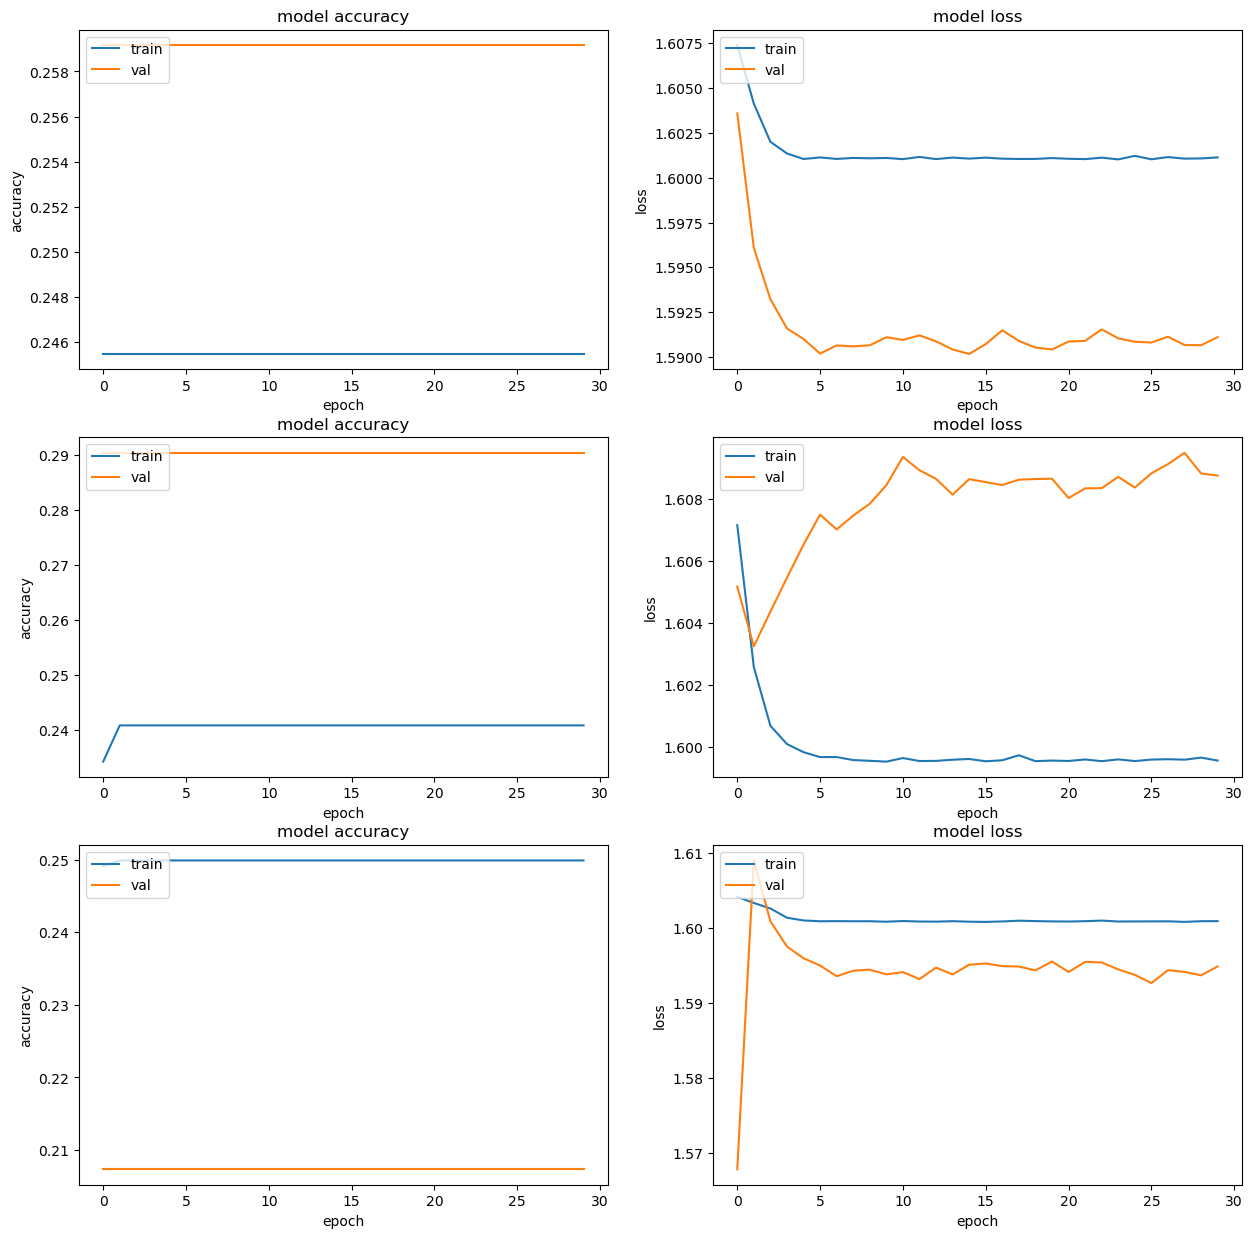

In [32]:
plot_stats(t3)

In [33]:
def get_m4():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Conv2D(8, kernel_size=(5,5), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2,2), strides=2),

            Conv2D(16, kernel_size=(3,3), activation='relu'),
            MaxPooling2D(pool_size=(2,2), strides=2),
            Conv2D(32, kernel_size=(3,3), activation='relu'),
            MaxPooling2D(pool_size=(2,2), strides=1),
            Flatten(),
            Dense(16, activation='relu'),
            Dense(5, activation='softmax')
    ])
    return m

get_m4().summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 257, 124, 8)       208       
_________________________________________________________________
batch_normalization_15 (Batc (None, 257, 124, 8)       32        
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 128, 62, 8)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 126, 60, 16)       1168      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 63, 30, 16)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 61, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 60, 27, 32)      

In [34]:
t4 = train_kfold(kf, metadata, get_m4, data['x'], data['y'])

Epoch 1/30
117/117 [==============================] - 2s 12ms/step - loss: 1.6082 - accuracy: 0.2336 - val_loss: 1.6024 - val_accuracy: 0.2592
Epoch 2/30
117/117 [==============================] - 1s 10ms/step - loss: 1.6023 - accuracy: 0.2553 - val_loss: 1.6003 - val_accuracy: 0.2592
Epoch 3/30
117/117 [==============================] - 1s 11ms/step - loss: 1.6031 - accuracy: 0.2471 - val_loss: 1.5957 - val_accuracy: 0.2592
Epoch 4/30
117/117 [==============================] - 1s 10ms/step - loss: 1.6019 - accuracy: 0.2390 - val_loss: 1.5934 - val_accuracy: 0.2592
Epoch 5/30
117/117 [==============================] - 1s 10ms/step - loss: 1.6029 - accuracy: 0.2415 - val_loss: 1.5922 - val_accuracy: 0.2592
Epoch 6/30
117/117 [==============================] - 1s 11ms/step - loss: 1.6003 - accuracy: 0.2507 - val_loss: 1.5922 - val_accuracy: 0.2592
Epoch 7/30
117/117 [==============================] - 1s 10ms/step - loss: 1.6015 - accuracy: 0.2409 - val_loss: 1.5910 - val_accuracy: 0.2592

Epoch 28/30
115/115 [==============================] - 1s 10ms/step - loss: 1.6009 - accuracy: 0.2382 - val_loss: 1.6080 - val_accuracy: 0.2903
Epoch 29/30
115/115 [==============================] - 1s 11ms/step - loss: 1.6007 - accuracy: 0.2356 - val_loss: 1.6095 - val_accuracy: 0.2903
Epoch 30/30
115/115 [==============================] - 1s 11ms/step - loss: 1.5996 - accuracy: 0.2345 - val_loss: 1.6094 - val_accuracy: 0.2903
Done
Epoch 1/30
121/121 [==============================] - 2s 11ms/step - loss: 1.6072 - accuracy: 0.2310 - val_loss: 1.6021 - val_accuracy: 0.2074
Epoch 2/30
121/121 [==============================] - 1s 10ms/step - loss: 1.6018 - accuracy: 0.2500 - val_loss: 1.5986 - val_accuracy: 0.2074
Epoch 3/30
121/121 [==============================] - 1s 10ms/step - loss: 1.6005 - accuracy: 0.2524 - val_loss: 1.5960 - val_accuracy: 0.2074
Epoch 4/30
121/121 [==============================] - 1s 10ms/step - loss: 1.6032 - accuracy: 0.2488 - val_loss: 1.5988 - val_accuracy

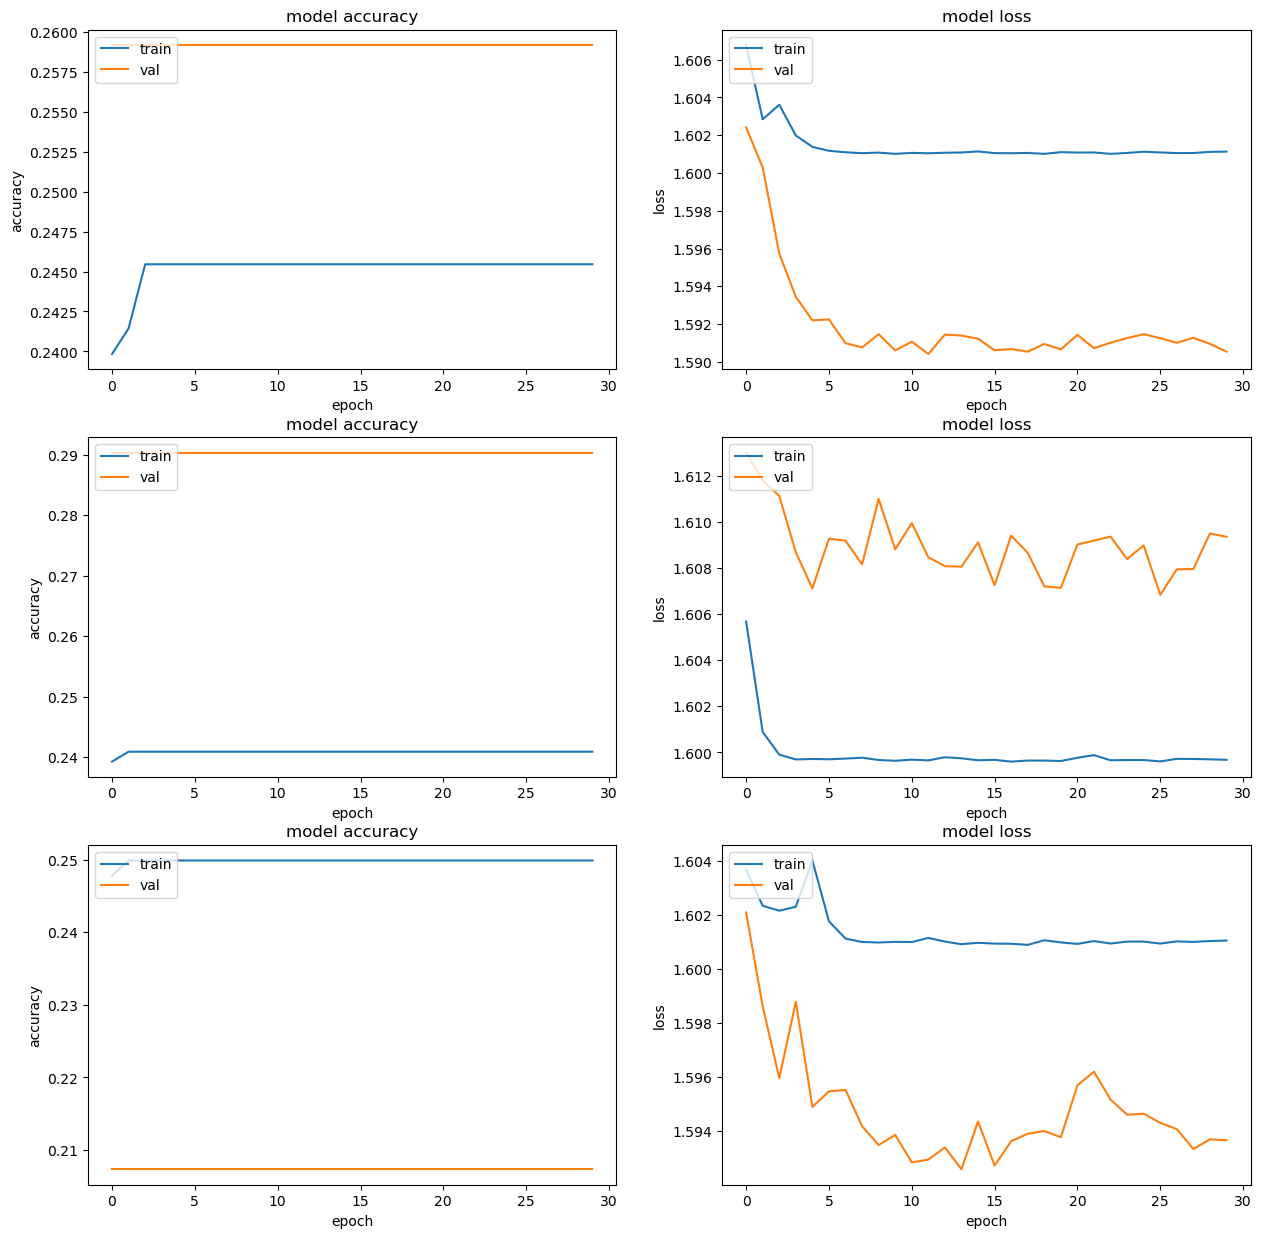

In [35]:
plot_stats(t4)

In [38]:
def get_m5():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(8, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            Bidirectional(LSTM(1, return_sequences=False, dropout=0.2)),
            
            Dense(5, activation='softmax')
    ])
    return m

get_m5().summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_75 (TimeDis (None, 9, 25, 124, 8)     208       
_________________________________________________________________
time_distributed_76 (TimeDis (None, 9, 25, 124, 8)     32        
_________________________________________________________________
time_distributed_77 (TimeDis (None, 9, 12, 62, 8)      0         
_________________________________________________________________
time_distributed_78 (TimeDis (None, 9, 10, 60, 16)     1168      
_________________________________________________________________
time_distributed_79 (TimeDis (None, 9, 9, 59, 16)      0         
_________________________________________________________________
time_distributed_80 (TimeDis (None, 9, 7, 57, 32)    

In [39]:
t5 = train_kfold(kf, metadata, get_m5, data['x'], data['y'])

Epoch 1/30
117/117 [==============================] - 4s 19ms/step - loss: 1.6077 - accuracy: 0.2162 - val_loss: 1.6001 - val_accuracy: 0.2592
Epoch 2/30
117/117 [==============================] - 2s 15ms/step - loss: 1.6036 - accuracy: 0.2353 - val_loss: 1.5940 - val_accuracy: 0.2592
Epoch 3/30
117/117 [==============================] - 2s 15ms/step - loss: 1.6019 - accuracy: 0.2384 - val_loss: 1.5892 - val_accuracy: 0.2592
Epoch 4/30
117/117 [==============================] - 2s 15ms/step - loss: 1.6023 - accuracy: 0.2474 - val_loss: 1.5910 - val_accuracy: 0.2592
Epoch 5/30
117/117 [==============================] - 2s 15ms/step - loss: 1.5986 - accuracy: 0.2560 - val_loss: 1.5929 - val_accuracy: 0.2592
Epoch 6/30
117/117 [==============================] - 2s 15ms/step - loss: 1.6011 - accuracy: 0.2479 - val_loss: 1.5886 - val_accuracy: 0.2592
Epoch 7/30
117/117 [==============================] - 2s 15ms/step - loss: 1.6016 - accuracy: 0.2458 - val_loss: 1.5921 - val_accuracy: 0.2592

Epoch 28/30
115/115 [==============================] - 2s 15ms/step - loss: 0.8301 - accuracy: 0.6668 - val_loss: 1.2054 - val_accuracy: 0.4718
Epoch 29/30
115/115 [==============================] - 2s 15ms/step - loss: 0.8230 - accuracy: 0.6729 - val_loss: 2.3465 - val_accuracy: 0.1996
Epoch 30/30
115/115 [==============================] - 2s 15ms/step - loss: 0.8147 - accuracy: 0.6669 - val_loss: 1.1169 - val_accuracy: 0.5060
Done
Epoch 1/30
121/121 [==============================] - 4s 19ms/step - loss: 1.6061 - accuracy: 0.2587 - val_loss: 1.5884 - val_accuracy: 0.2074
Epoch 2/30
121/121 [==============================] - 2s 14ms/step - loss: 1.6008 - accuracy: 0.2546 - val_loss: 1.5865 - val_accuracy: 0.2074
Epoch 3/30
121/121 [==============================] - 2s 15ms/step - loss: 1.6015 - accuracy: 0.2524 - val_loss: 1.5980 - val_accuracy: 0.2074
Epoch 4/30
121/121 [==============================] - 2s 15ms/step - loss: 1.6000 - accuracy: 0.2500 - val_loss: 1.5941 - val_accuracy

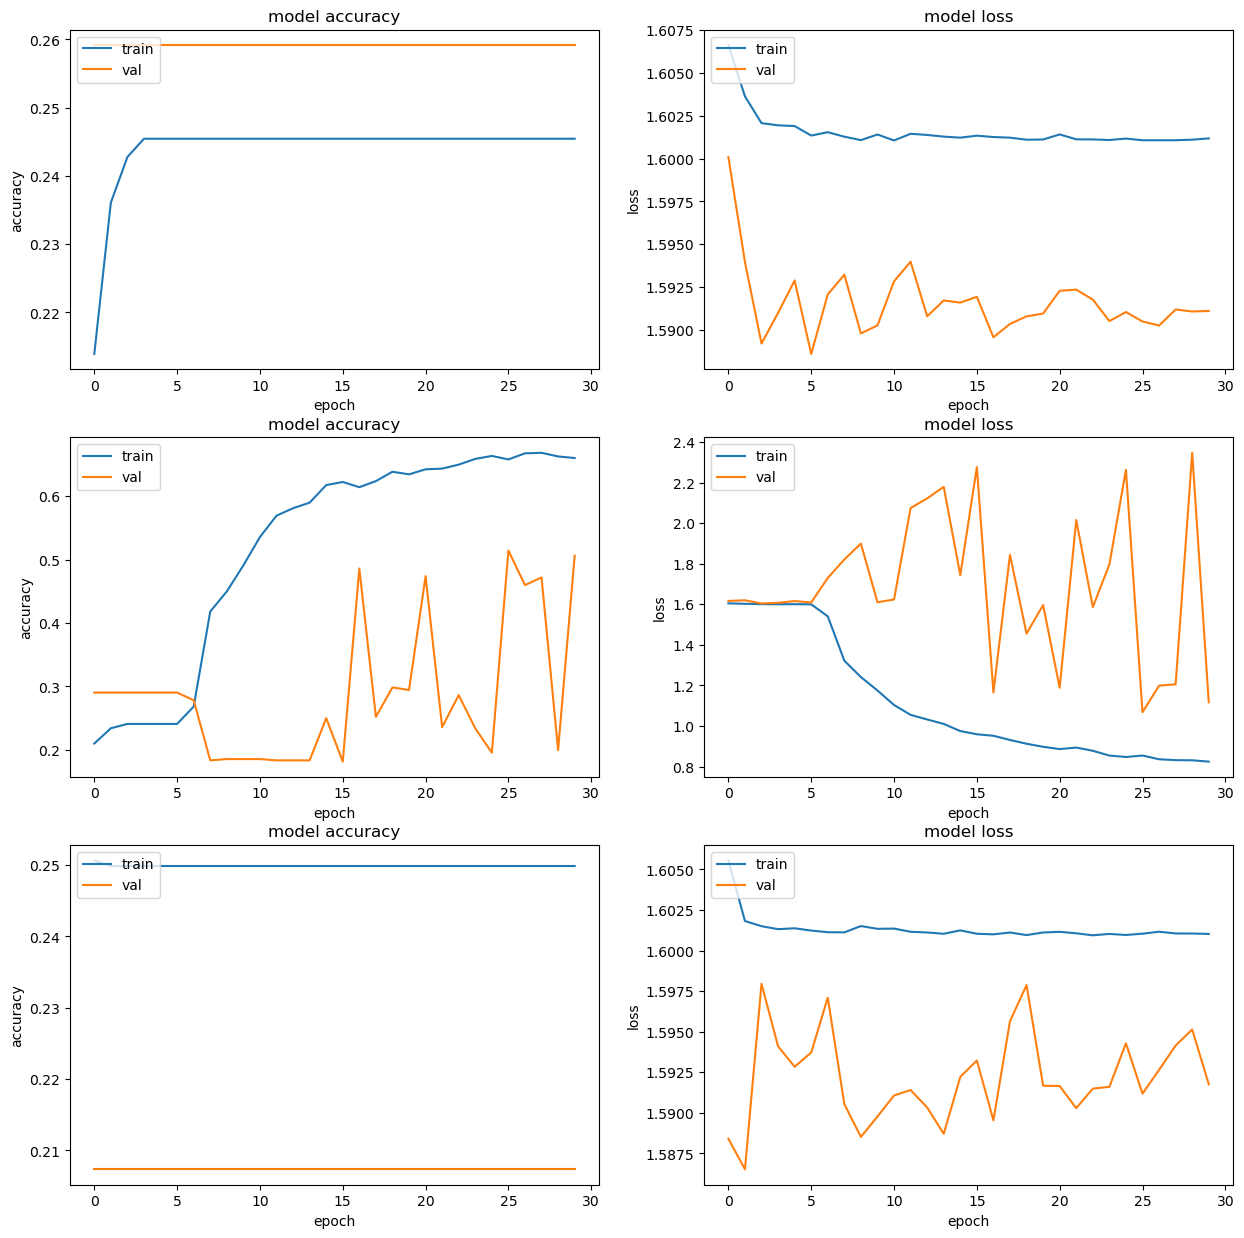

In [40]:
plot_stats(t5)

In [26]:
def get_m13():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(8, dropout=0.4, return_sequences=True),
            LSTM(4, return_sequences=False),
            
            Dense(5, activation='softmax')
    ])
    return m

get_m13().summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_40 (TimeDis (None, 9, 27, 126, 16)    160       
_________________________________________________________________
time_distributed_41 (TimeDis (None, 9, 27, 126, 16)    64        
_________________________________________________________________
time_distributed_42 (TimeDis (None, 9, 13, 63, 16)     0         
_________________________________________________________________
time_distributed_43 (TimeDis (None, 9, 11, 61, 32)     4640      
_________________________________________________________________
time_distributed_44 (TimeDis (None, 9, 10, 60, 32)     0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 9, 8, 58, 64)     

In [27]:
t2 = train_kfold(kf, metadata, get_m13, data['x'], data['y'])

Epoch 1/30
117/117 [==============================] - 5s 25ms/step - loss: 1.6054 - accuracy: 0.2509 - val_loss: 1.5893 - val_accuracy: 0.2592
Epoch 2/30
117/117 [==============================] - 2s 19ms/step - loss: 1.6026 - accuracy: 0.2376 - val_loss: 1.5944 - val_accuracy: 0.2592
Epoch 3/30
117/117 [==============================] - 2s 19ms/step - loss: 1.5979 - accuracy: 0.2571 - val_loss: 1.5923 - val_accuracy: 0.2592
Epoch 4/30
117/117 [==============================] - 2s 19ms/step - loss: 1.6015 - accuracy: 0.2449 - val_loss: 1.5907 - val_accuracy: 0.2592
Epoch 5/30
117/117 [==============================] - 2s 19ms/step - loss: 1.6013 - accuracy: 0.2400 - val_loss: 1.5927 - val_accuracy: 0.2592
Epoch 6/30
117/117 [==============================] - 2s 20ms/step - loss: 1.5992 - accuracy: 0.2481 - val_loss: 1.5917 - val_accuracy: 0.2592
Epoch 7/30
117/117 [==============================] - 2s 19ms/step - loss: 1.6002 - accuracy: 0.2415 - val_loss: 1.5915 - val_accuracy: 0.2592

Epoch 28/30
115/115 [==============================] - 2s 20ms/step - loss: 1.5997 - accuracy: 0.2399 - val_loss: 1.6084 - val_accuracy: 0.2903
Epoch 29/30
115/115 [==============================] - 2s 20ms/step - loss: 1.6010 - accuracy: 0.2482 - val_loss: 1.6083 - val_accuracy: 0.2903
Epoch 30/30
115/115 [==============================] - 2s 20ms/step - loss: 1.5978 - accuracy: 0.2487 - val_loss: 1.6091 - val_accuracy: 0.2903
Done
Epoch 1/30
121/121 [==============================] - 5s 24ms/step - loss: 1.6062 - accuracy: 0.2445 - val_loss: 1.5720 - val_accuracy: 0.2074
Epoch 2/30
121/121 [==============================] - 2s 20ms/step - loss: 1.6004 - accuracy: 0.2535 - val_loss: 1.5918 - val_accuracy: 0.2074
Epoch 3/30
121/121 [==============================] - 2s 20ms/step - loss: 1.6027 - accuracy: 0.2463 - val_loss: 1.5895 - val_accuracy: 0.2074
Epoch 4/30
121/121 [==============================] - 2s 19ms/step - loss: 1.6022 - accuracy: 0.2480 - val_loss: 1.5856 - val_accuracy

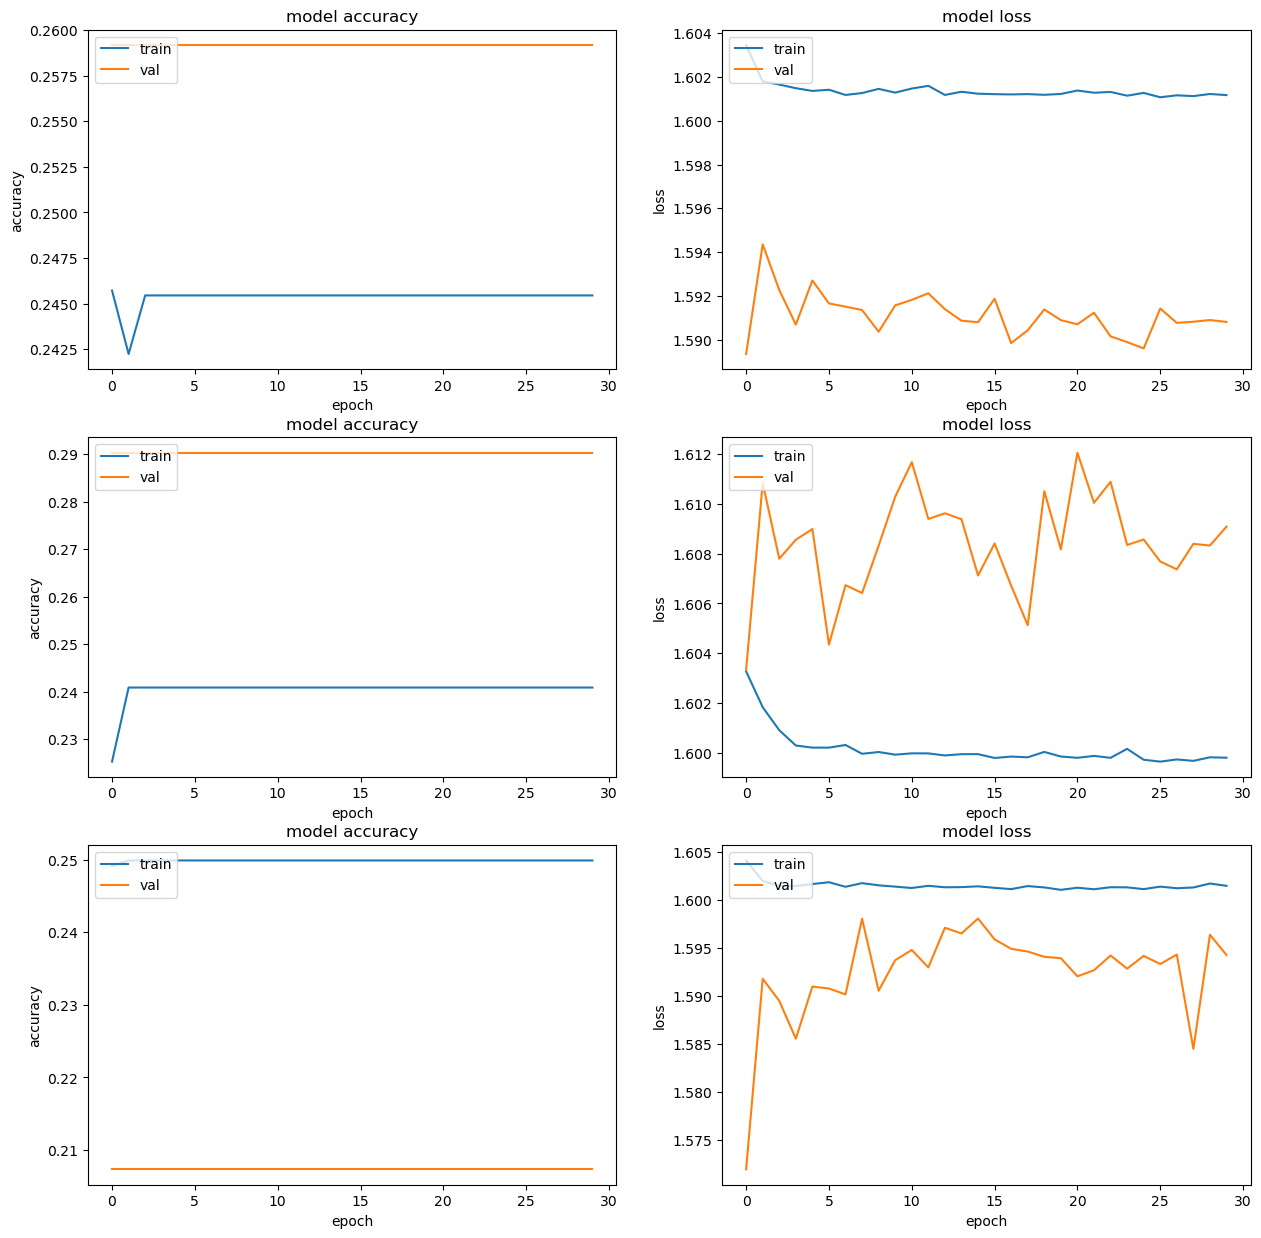

In [28]:
plot_stats(t2)

In [36]:
def get_m14():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Reshape((16,16,256,3)),
            TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            Bidirectional(LSTM(8, dropout=0.4, return_sequences=True)),
            LSTM(4, return_sequences=False),
            
            Dense(7, activation='softmax')
    ])
    return m

get_m14().summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_32 (Reshape)         (None, 16, 16, 256, 3)    0         
_________________________________________________________________
time_distributed_261 (TimeDi (None, 16, 14, 254, 16)   448       
_________________________________________________________________
time_distributed_262 (TimeDi (None, 16, 14, 254, 16)   64        
_________________________________________________________________
time_distributed_263 (TimeDi (None, 16, 7, 127, 16)    0         
_________________________________________________________________
time_distributed_264 (TimeDi (None, 16, 5, 125, 32)    4640      
_________________________________________________________________
time_distributed_265 (TimeDi (None, 16, 4, 124, 32)    0         
_________________________________________________________________
time_distributed_266 (TimeDi (None, 16, 2, 122, 64)  

In [37]:
ac1_14 = train_avaluate(get_m14, kf1, data["emodb"]["x"], data["emodb"]["y"] )

Epoch 1/30
89/89 [==============================] - 9s 70ms/step - loss: 1.8793 - accuracy: 0.2378 - val_loss: 1.9070 - val_accuracy: 0.2783
Epoch 2/30
89/89 [==============================] - 5s 61ms/step - loss: 1.7533 - accuracy: 0.4097 - val_loss: 1.8034 - val_accuracy: 0.4601
Epoch 3/30
89/89 [==============================] - 5s 56ms/step - loss: 1.5973 - accuracy: 0.4602 - val_loss: 1.6771 - val_accuracy: 0.4657
Epoch 4/30
89/89 [==============================] - 5s 60ms/step - loss: 1.4962 - accuracy: 0.4819 - val_loss: 1.6530 - val_accuracy: 0.4063
Epoch 5/30
89/89 [==============================] - 6s 62ms/step - loss: 1.4118 - accuracy: 0.4973 - val_loss: 1.5113 - val_accuracy: 0.4007
Epoch 6/30
89/89 [==============================] - 6s 63ms/step - loss: 1.3538 - accuracy: 0.5100 - val_loss: 1.4536 - val_accuracy: 0.4230
Epoch 7/30
89/89 [==============================] - 5s 62ms/step - loss: 1.3166 - accuracy: 0.5188 - val_loss: 1.4225 - val_accuracy: 0.4100
Epoch 8/30
89

Epoch 29/30
86/86 [==============================] - 5s 64ms/step - loss: 0.3052 - accuracy: 0.9264 - val_loss: 1.0182 - val_accuracy: 0.6635
Epoch 30/30
86/86 [==============================] - 5s 63ms/step - loss: 0.3330 - accuracy: 0.9140 - val_loss: 1.1139 - val_accuracy: 0.6255
Done
Epoch 1/30
83/83 [==============================] - 10s 78ms/step - loss: 1.9071 - accuracy: 0.2179 - val_loss: 1.8886 - val_accuracy: 0.1929
Epoch 2/30
83/83 [==============================] - 5s 65ms/step - loss: 1.7483 - accuracy: 0.4036 - val_loss: 1.8654 - val_accuracy: 0.2043
Epoch 3/30
83/83 [==============================] - 5s 65ms/step - loss: 1.5960 - accuracy: 0.4047 - val_loss: 1.7521 - val_accuracy: 0.2717
Epoch 4/30
83/83 [==============================] - 5s 66ms/step - loss: 1.4725 - accuracy: 0.4742 - val_loss: 1.7813 - val_accuracy: 0.2409
Epoch 5/30
83/83 [==============================] - 5s 65ms/step - loss: 1.3818 - accuracy: 0.5141 - val_loss: 1.7453 - val_accuracy: 0.2774
Epoch

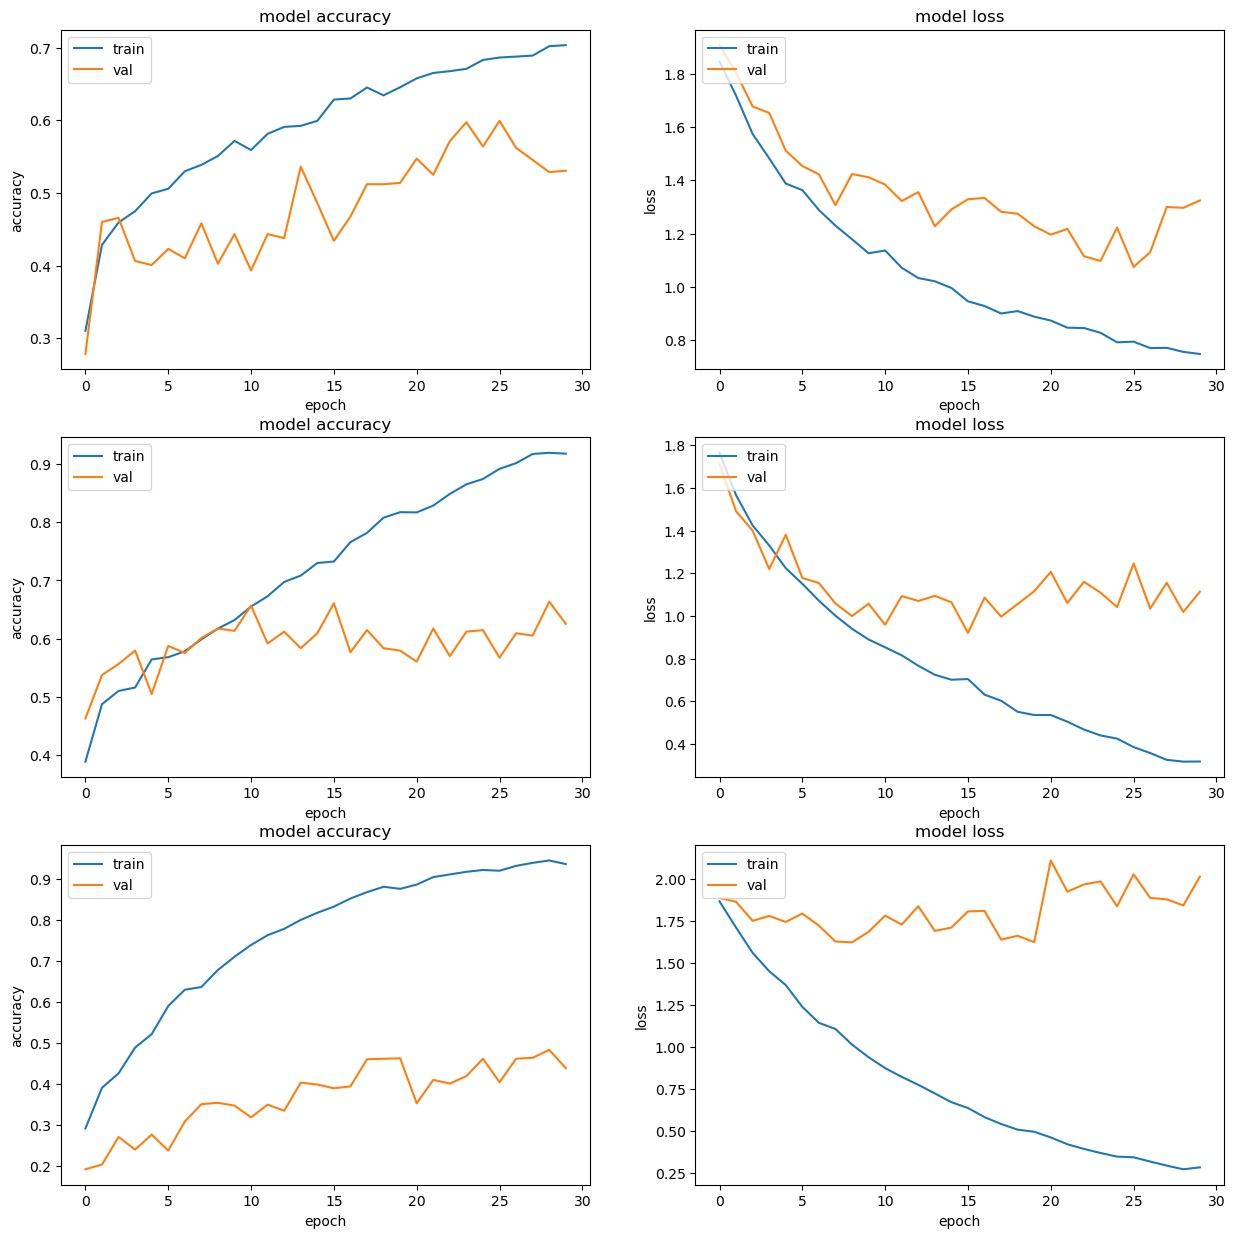

In [38]:
plot_stats(ac1_14)

In [39]:
def train_avaluate2(model_fn, kf, x, y):
    cv_acc = []
    for train_index, val_index in kf:
        m = model_fn()
        m.compile(loss='categorical_crossentropy', optimizer='sgd', metrics='accuracy')
        # fit & predict
        history = m.fit(x[train_index], y[train_index],
                        batch_size=64,
                        epochs=50,
                        validation_data=(x[val_index], y[val_index]),
                        verbose=1)
        print("Done")
        cv_acc.append(history)
    return cv_acc

In [40]:
ac1_15 = train_avaluate2(get_m13, kf1, data["emodb"]["x"], data["emodb"]["y"] )

Epoch 1/50
89/89 [==============================] - 8s 67ms/step - loss: 1.8489 - accuracy: 0.3102 - val_loss: 1.8787 - val_accuracy: 0.2375
Epoch 2/50
89/89 [==============================] - 5s 59ms/step - loss: 1.7109 - accuracy: 0.4026 - val_loss: 1.8590 - val_accuracy: 0.1688
Epoch 3/50
89/89 [==============================] - 5s 59ms/step - loss: 1.6444 - accuracy: 0.4056 - val_loss: 1.6642 - val_accuracy: 0.4193
Epoch 4/50
89/89 [==============================] - 5s 59ms/step - loss: 1.5767 - accuracy: 0.4086 - val_loss: 1.5181 - val_accuracy: 0.4545
Epoch 5/50
89/89 [==============================] - 5s 59ms/step - loss: 1.5249 - accuracy: 0.4301 - val_loss: 1.4669 - val_accuracy: 0.4286
Epoch 6/50
89/89 [==============================] - 5s 59ms/step - loss: 1.4647 - accuracy: 0.4589 - val_loss: 1.8509 - val_accuracy: 0.1280
Epoch 7/50
89/89 [==============================] - 5s 59ms/step - loss: 1.4425 - accuracy: 0.4772 - val_loss: 1.5928 - val_accuracy: 0.3451
Epoch 8/50
89

Epoch 9/50
86/86 [==============================] - 5s 60ms/step - loss: 1.4447 - accuracy: 0.5082 - val_loss: 1.2828 - val_accuracy: 0.6554
Epoch 10/50
86/86 [==============================] - 5s 60ms/step - loss: 1.3836 - accuracy: 0.5328 - val_loss: 1.3422 - val_accuracy: 0.6309
Epoch 11/50
86/86 [==============================] - 5s 60ms/step - loss: 1.3481 - accuracy: 0.5376 - val_loss: 1.6797 - val_accuracy: 0.3867
Epoch 12/50
86/86 [==============================] - 5s 61ms/step - loss: 1.3180 - accuracy: 0.5393 - val_loss: 1.5341 - val_accuracy: 0.4912
Epoch 13/50
86/86 [==============================] - 5s 61ms/step - loss: 1.3518 - accuracy: 0.5166 - val_loss: 1.5364 - val_accuracy: 0.4057
Epoch 14/50
86/86 [==============================] - 5s 59ms/step - loss: 1.2835 - accuracy: 0.5517 - val_loss: 1.1636 - val_accuracy: 0.6404
Epoch 15/50
86/86 [==============================] - 5s 60ms/step - loss: 1.2367 - accuracy: 0.5694 - val_loss: 1.5542 - val_accuracy: 0.5142
Epoch 1

Epoch 17/50
83/83 [==============================] - 5s 61ms/step - loss: 1.2010 - accuracy: 0.5828 - val_loss: 1.8849 - val_accuracy: 0.2797
Epoch 18/50
83/83 [==============================] - 5s 61ms/step - loss: 1.1928 - accuracy: 0.5756 - val_loss: 1.6491 - val_accuracy: 0.3333
Epoch 19/50
83/83 [==============================] - 5s 61ms/step - loss: 1.1731 - accuracy: 0.5854 - val_loss: 1.8402 - val_accuracy: 0.3356
Epoch 20/50
83/83 [==============================] - 5s 60ms/step - loss: 1.1305 - accuracy: 0.5875 - val_loss: 1.6335 - val_accuracy: 0.3584
Epoch 21/50
83/83 [==============================] - 5s 63ms/step - loss: 1.1070 - accuracy: 0.6040 - val_loss: 1.6075 - val_accuracy: 0.3836
Epoch 22/50
83/83 [==============================] - 5s 62ms/step - loss: 1.0834 - accuracy: 0.6059 - val_loss: 1.4949 - val_accuracy: 0.4247
Epoch 23/50
83/83 [==============================] - 5s 62ms/step - loss: 1.0820 - accuracy: 0.6044 - val_loss: 1.4117 - val_accuracy: 0.4281
Epoch 

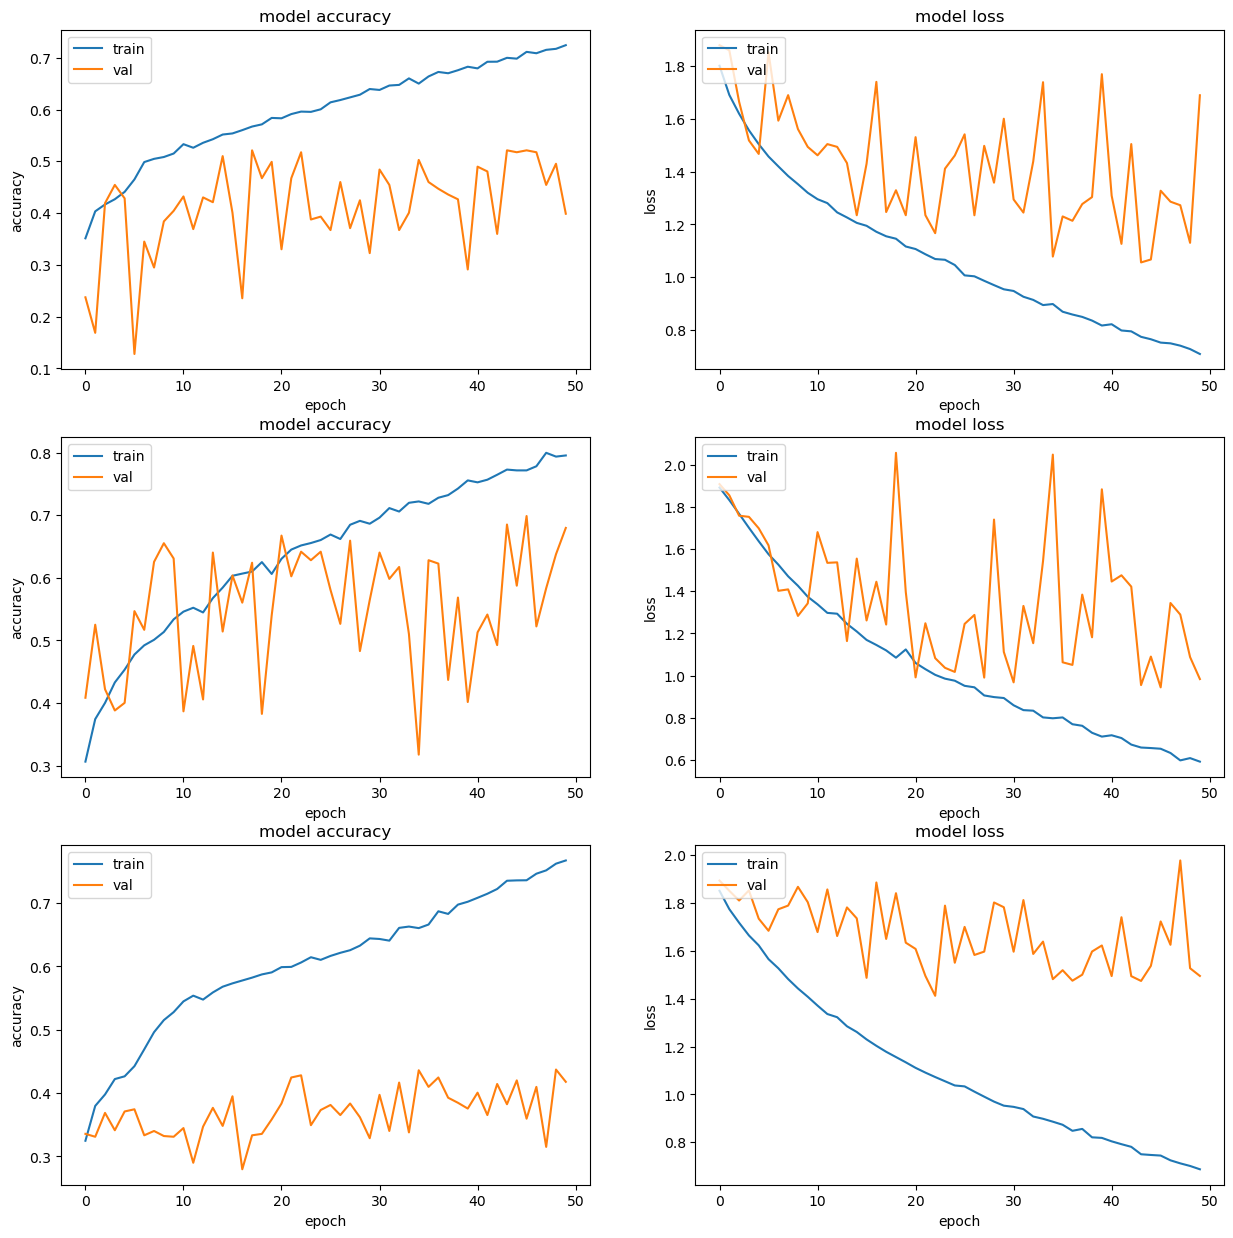

In [41]:
plot_stats(ac1_15)